In [244]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import OneHotEncoder

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

In [245]:
print(tf.__version__)

2.12.0


In [246]:
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self, metrics=[]):
        self.print_metrics = metrics
        print(self.print_metrics)

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        # Plotting
        metrics = [x for x in logs if 'val' not in x and x in self.print_metrics]

        f, axs = plt.subplots(len(metrics)//2 , 2, figsize=(20,10))
        
        clear_output(wait=True)
        axs = list(np.array(axs).flatten())

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric],
                        label=metric)
            
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([min(min(history.history['loss']), min(history.history['val_loss']))*0.8, max(max(history.history['loss']), max(history.history['val_loss']))*1.1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [monthly spend]')
    plt.legend()
    plt.grid(True)

In [247]:
dataset = pd.read_json('train_data.json')
dataset = dataset.drop(columns = ['time_as_client', 'profit', 'compliant'])

target = 'monthly_spend'

In [248]:
dataset

,residence_1_2_years,residence_3_years,residence_6_months_or_less,residence_7_12_months,bank_1_2_years,bank_3_years,bank_6_months_or_less,bank_7_12_months,monthly_income,monthly_rent,...,approved_income_ratio,score_tu,score_fico_money,score_lexisnexis,score_serasa,score_unit4,credit_line_requested,credit_line_approved,app_req_ratio,monthly_spend
0,0,0,1,0,0,1,0,0,1323.062313,950,...,0.831405,411,699,440,102,418,1500,1100,0.733333,9
1,0,1,0,0,0,1,0,0,6400.531602,2400,...,3.890302,753,850,575,89,385,25500,24900,0.976471,2771
2,1,0,0,0,0,1,0,0,1400.499240,100,...,5.783652,478,646,464,670,213,9000,8100,0.900000,866
3,0,1,0,0,0,0,1,0,1275.467006,0,...,3.606522,780,850,690,305,398,5500,4600,0.836364,896
5,1,0,0,0,0,0,1,0,1725.387863,900,...,17.271479,200,319,200,244,415,30500,29800,0.977049,590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9216,0,1,0,0,0,0,0,1,4512.606902,2450,...,0.598324,719,695,652,0,675,4500,2700,0.600000,1575
9217,0,1,0,0,1,0,0,0,2302.179408,1400,...,0.521245,200,100,265,0,205,1500,1200,0.800000,540
9218,0,1,0,0,0,1,0,0,843.608551,250,...,1.303922,727,519,592,38,580,1500,1100,0.733333,287
9219,0,1,0,0,0,0,1,0,3165.962014,2300,...,0.379032,784,717,656,197,352,2000,1200,0.600000,623


In [190]:
train_dataset = dataset.sample(frac=0.9, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [216]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

features = test_features.columns.drop(target)

train_labels = train_features.pop(target)
test_labels = test_features.pop(target)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))


In [220]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(32, activation='linear'),
        layers.Dense(64, activation='linear'),
        layers.Dense(8, activation='relu'),
        # layers.Dense(8, activation=lambda x: x**2),
        # layers.Dense(8, activation='relu'),
        # layers.Dropout(0.5),
        # layers.Dense(8, activation='relu'),
        layers.Dense(1)
    ])


    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                    0.5,
                    decay_steps = 1000,
                    decay_rate=10,
                    staircase=False)
    
    model.compile(loss='mean_absolute_error', metrics=[tf.keras.metrics.RootMeanSquaredError()],
                  optimizer=tf.keras.optimizers.Adam(lr_schedule))

    model.save_weights('initial_mspend_model.h5')
    
    return model



In [221]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 21)               43        
 ion)                                                            
                                                                 
 dense_60 (Dense)            (None, 32)                704       
                                                                 
 dense_61 (Dense)            (None, 64)                2112      
                                                                 
 dense_62 (Dense)            (None, 8)                 520       
                                                                 
 dense_63 (Dense)            (None, 1)                 9         
                                                                 
Total params: 3,388
Trainable params: 3,345
Non-trainable params: 43
__________________________________________________

In [222]:
metrics_to_plot = ['loss', 'root_mean_squared_error']
callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=25)]

dnn_model.load_weights('initial_mspend_model.h5')

# history = dnn_model.fit(
#     train_features,
#     train_labels,
#     validation_split=0.2,
#     verbose=1, 
#     epochs=200,
#     callbacks=callbacks_list)

['loss', 'root_mean_squared_error']


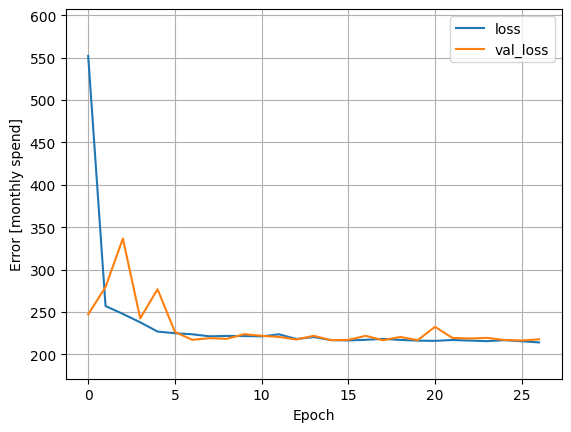

In [223]:
plot_loss(history)

26/26 [==============================] - 0s 796us/step


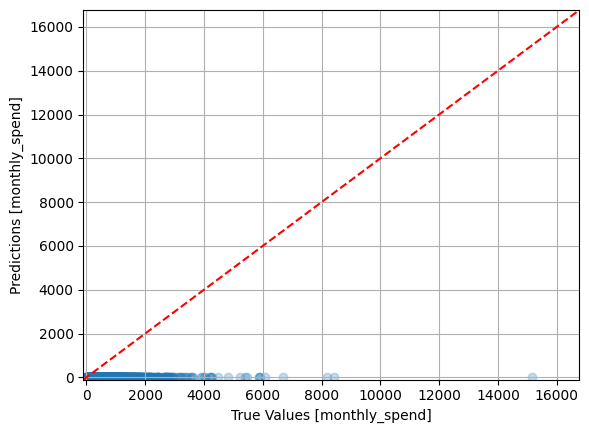

In [224]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [min(min(test_labels), min(test_predictions))*0.9 - 100, max(max(test_labels), max(test_predictions))*1.1 + 100]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.plot(lims, lims, 'r--')

count      821.000000
mean     -1031.913168
std       1136.395891
min     -15156.144609
25%      -1370.485273
50%       -786.820673
75%       -306.973705
max          0.150793
Name: monthly_spend, dtype: float64


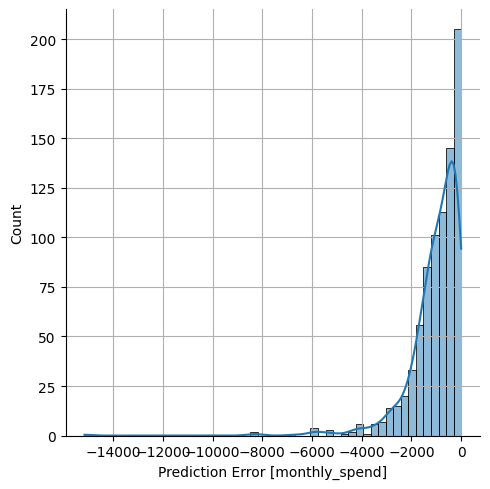

In [225]:
error = test_predictions - test_labels
print(error.describe())
sns.displot(error, bins=50, kde=True)
plt.grid()
plt.xlabel('Prediction Error [monthly_spend]')
_ = plt.ylabel('Count')

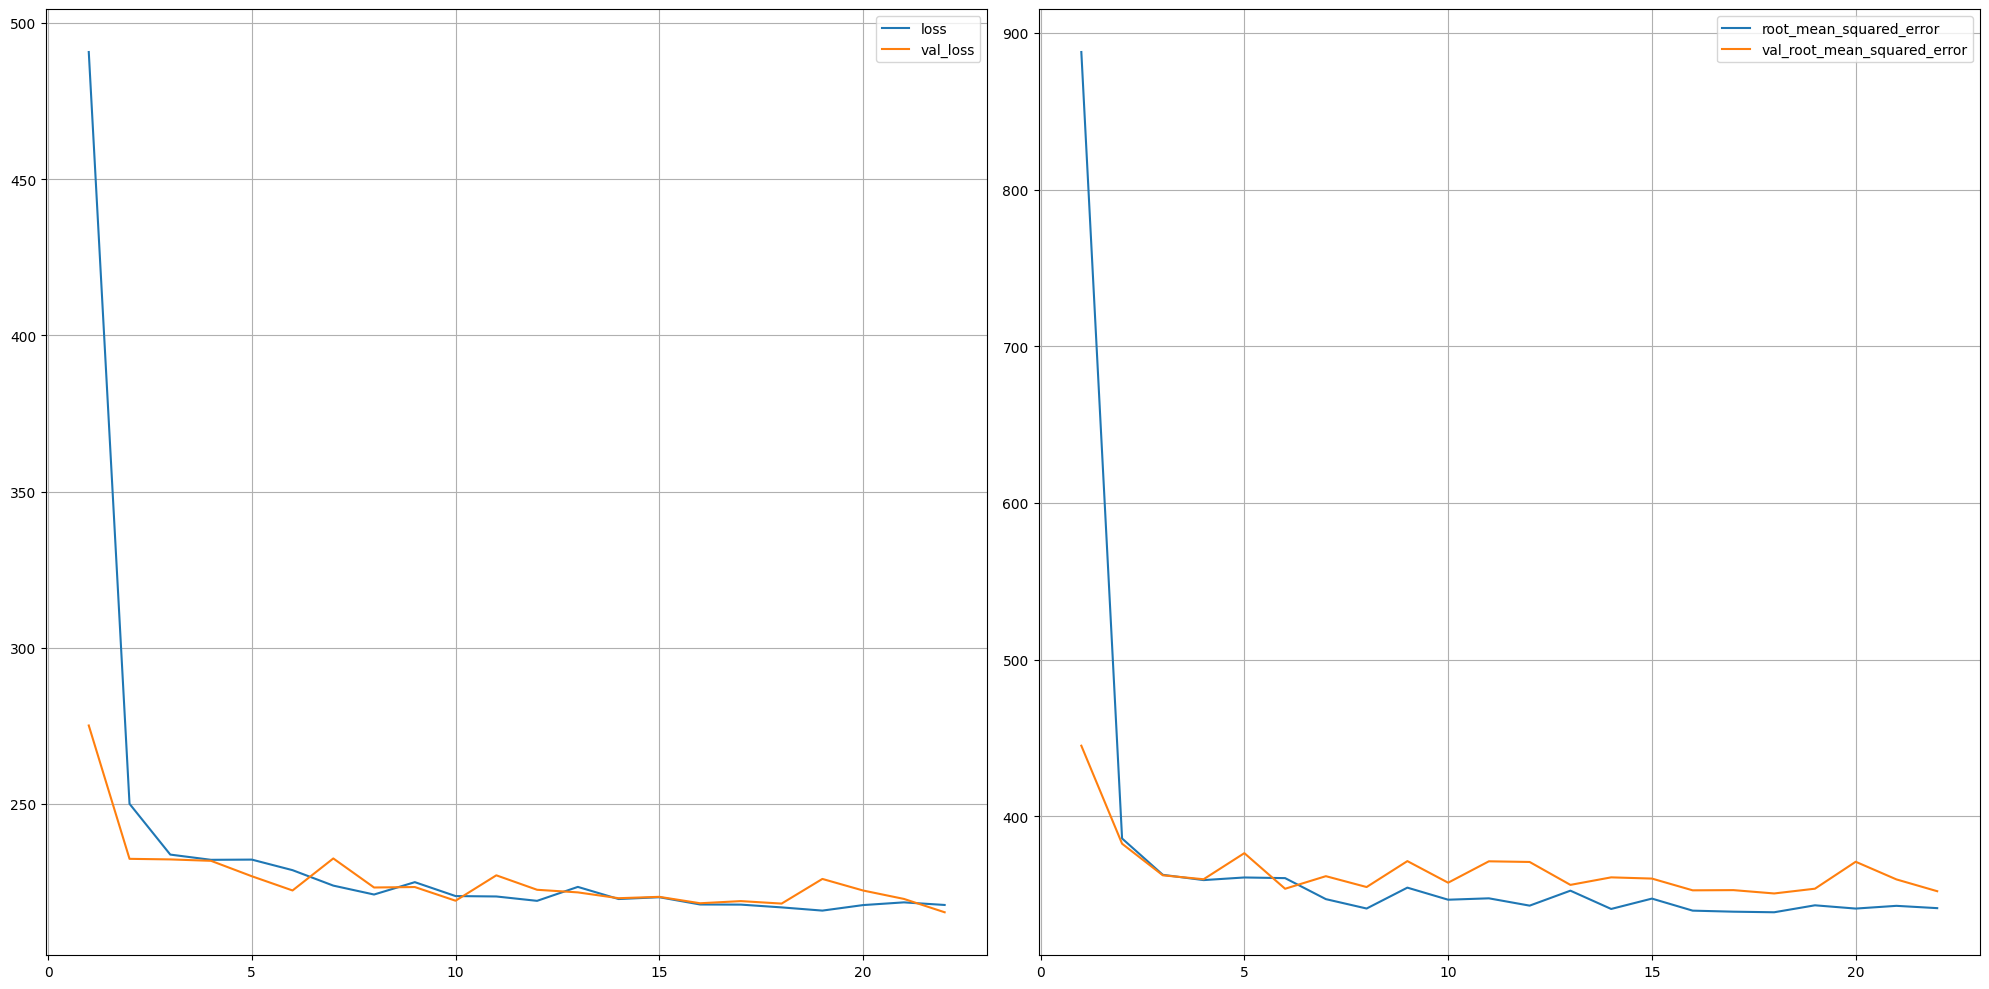

185/185 [==============================] - 1s 3ms/step - loss: 217.6803 - root_mean_squared_error: 341.3857 - val_loss: 215.3440 - val_root_mean_squared_error: 352.1996


In [226]:
metrics_to_plot = ['loss', 'root_mean_squared_error']
callbacks_list = [PlotLearning(metrics_to_plot),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=25)]

dnn_model.load_weights('initial_mspend_model.h5')

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, 
    epochs=200,
    callbacks=callbacks_list)

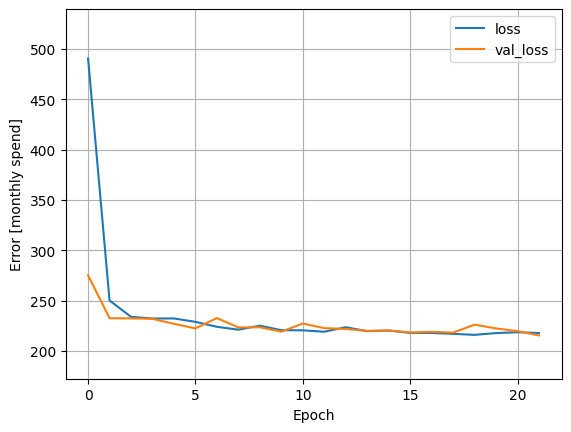

In [227]:
plot_loss(history)

26/26 [==============================] - 0s 786us/step


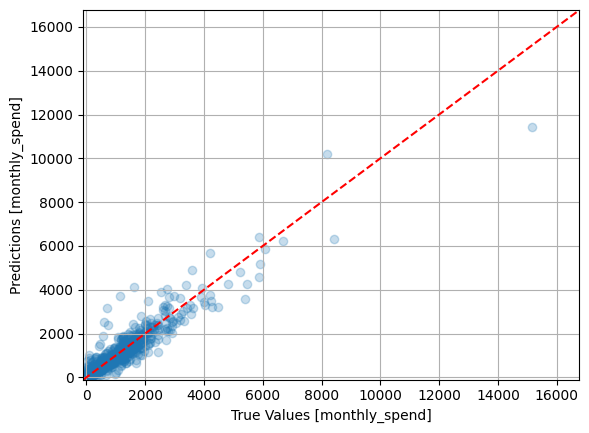

In [228]:
dnn_model.evaluate(test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features).flatten()

plt.scatter(test_labels, test_predictions, alpha=0.25)
plt.xlabel('True Values [monthly_spend]')
plt.ylabel('Predictions [monthly_spend]')
lims = [min(min(test_labels), min(test_predictions))*0.9 - 100, max(max(test_labels), max(test_predictions))*1.1 + 100]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.plot(lims, lims, 'r--')

count     821.000000
mean      -15.113876
std       400.194276
min     -3740.212891
25%      -133.900330
50%       -21.427246
75%       100.601440
max      2571.279053
Name: monthly_spend, dtype: float64


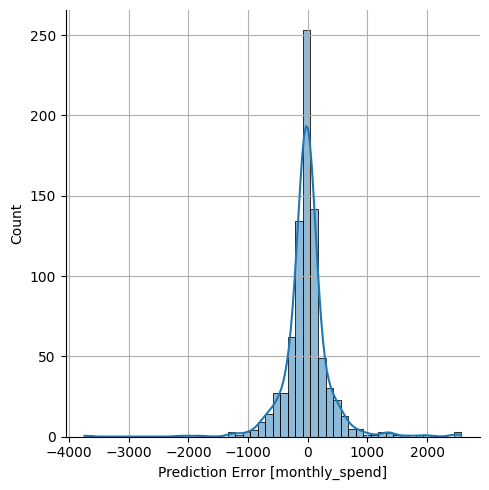

In [229]:
error = test_predictions - test_labels
print(error.describe())
sns.displot(error, bins=50, kde=True)
plt.grid()
plt.xlabel('Prediction Error [monthly_spend]')
_ = plt.ylabel('Count')

32/32 [==============================] - 0s 859us/step


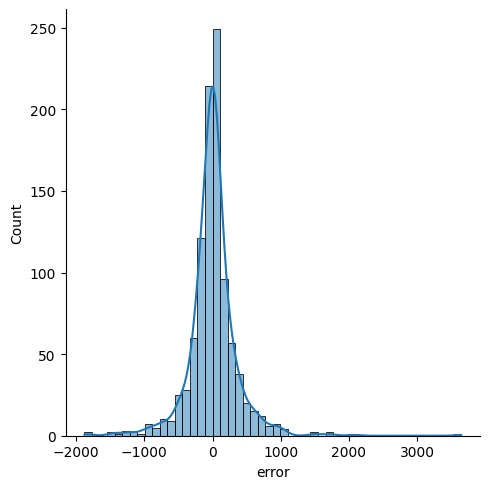

In [239]:
original_test_dataset = pd.read_json('test_data.json')
test_dataset_features = original_test_dataset[features]
test_dataset_target = original_test_dataset[[target]].copy()
predictions = dnn_model.predict(test_dataset_features).flatten()
original_test_dataset['predicted_monthly_spend'] = predictions
test_dataset_target['error'] = test_dataset_target[target] - original_test_dataset['predicted_monthly_spend']
sns.displot(test_dataset_target['error'], bins=50, kde=True)

In [243]:
dnn_model.save('m_spend_regressor.dnn')

INFO:tensorflow:Assets written to: m_spend_regressor.dnn/assets


INFO:tensorflow:Assets written to: m_spend_regressor.dnn/assets
